# Setup

In [1]:
!pip install fastai > /dev/null

In [2]:
import pandas as pd

from fastai.tabular.all import *

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [76]:
pd_clean_train = pd.read_csv("./data/clean/train.csv", index_col='PassengerId')
pd_clean_test = pd.read_csv("./data/clean/test.csv", index_col='PassengerId')
pd_sample_submission = pd.read_csv("../input/sample_submission.csv")

In [77]:
pd_clean_train.info()
pd_clean_train.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S


# Create Modeling Datasets

In [112]:
CONT_FEATS = ['Age', 'Fare']
CAT_FEATS = ['Sex', 'SibSp', 'Embarked', 'Pclass', 'Parch']


def format_dataset(pd_df):
    dataset_cols = CONT_FEATS + CAT_FEATS + ['Survived']
    
    return pd_df.loc[:, [col for col in dataset_cols if col in pd_df.columns]]


def transform_survived_col(pd_df):
    return pd_df.assign(Survived=pd_df.Survived.astype(np.float16))

In [113]:
pd_model_train = (pd_clean_train
    .pipe(transform_survived_col)
    .pipe(format_dataset))
pd_model_test = (pd_clean_test
    .pipe(format_dataset))

# Train-Validation Split

In [114]:
pd_train = pd_model_train.sample(frac = 0.8, random_state=3)
pd_valid = pd_model_train.drop(pd_train.index)

# Create Modeling Dataset

In [115]:
splits = (list(pd_train.index.values), list(pd_valid.index.values))
procs = [Categorify, FillMissing, Normalize]

In [116]:
tp_train = TabularPandas(
    df=pd_model_train, 
    procs=procs, 
    cat_names=CAT_FEATS, 
    cont_names=CONT_FEATS, 
    y_names='Survived', 
    splits=splits)

In [117]:
# Save
save_pickle('./data/model/nn_tp_train.pkl', tp_train)

In [118]:
# Read
tp_train = pickle.load(open('./data/model/nn_tp_train.pkl', "rb"))

# Train Model

In [119]:
# Define model
dls = tp_train.dataloaders(1024)
learner = tabular_learner(
    dls=dls, 
    y_range=(0,1), 
    metrics=accuracy,
    loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0014454397605732083)

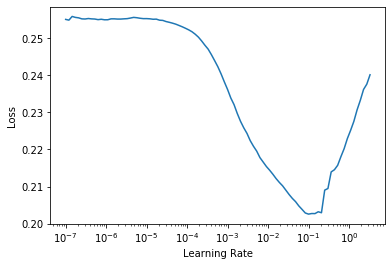

In [120]:
# Find optimal learning rate
learner.lr_find()

In [121]:
# Fit model
learner.fit_one_cycle(15, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.192232,0.185417,0.574100,00:02
1,0.165697,0.161999,0.574100,00:02
2,0.161390,0.162559,0.574100,00:02
3,0.160304,0.161886,0.574100,00:02
4,0.159647,0.161641,0.574100,00:02
5,0.158980,0.161817,0.574100,00:02
6,0.159244,0.161215,0.574100,00:02
7,0.158643,0.161418,0.574100,00:02
8,0.158851,0.161645,0.574100,00:02
9,0.158326,0.161367,0.574100,00:02


In [122]:
# Save model
!rm ./models/nn.pth  # remove previously saved model
learner.save('nn')  # automatically prefixes "./models/"

Path('models/nn.pth')

In [123]:
# Read model
learner.load('nn')  # automatically prefixes "./models/"
learner.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(4, 3)
    (4): Embedding(9, 5)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=27, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=1)
  )
)

# Evaluate Model

# Create Submission

In [124]:
# Process test dataset
tp_test = tp_train.new(pd_model_test)
tp_test.process()
tst_dl = dls.valid.new(tp_test)

In [125]:
# Compute predictions
preds, _ = learner.get_preds(dl=tst_dl)
labels = [pred.item() for pred in np.argmax(preds, 1)]

In [126]:
# Create sumbission dataset
pd_submission = pd_sample_submission.assign(Survived=labels)
pd_submission.to_csv('./submissions/2.1-modelling-fastai.csv', index=False)